### Imports

In [227]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## preprocessing - NLP
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

## workflow
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

## models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier

## metrics
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

In [2]:
%run 00_Workflow_Functions.ipynb import na_only, make_model

In [3]:
# recovering train and test data
%store -r stored_data

In [4]:
X_train = stored_data['X_train']
X_test = stored_data['X_test']

y_train_encoded = stored_data['y_train_encoded']
y_test_encoded = stored_data['y_test_encoded']

### Vectorizing Data

For our first model iteration, we will do a simple vectorization of text data. We will then evaluate our model performance and further engineer our text features.

In [5]:
cvec = CountVectorizer()

In [6]:
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train).A, columns=cvec.get_feature_names_out())
X_test_cvec = pd.DataFrame(cvec.transform(X_test).A, columns=cvec.get_feature_names_out())
X_train_cvec.head(5)

,00,000,00001,026_007_plumb_repair,03,03am,04,054fd209,08,087,...,還是因為距離,還會陷入愛情嗎,那些懵懂而青澀的過往,那些沒有結果的感情,那個你本以為忘記的人,都成眷屬,都會實現,都會結果,都有可能改變你的生活,餘生
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
print(X_train_cvec.shape, X_test_cvec.shape)

(1857, 12373) (619, 12373)


In [78]:
cvec_top_20 = X_train_cvec.sum().sort_values(ascending=False)[:20]
cvec_top_20

the     5813
to      5415
and     4540
you     4057
it      3075
of      2726
in      2164
that    2072
for     1982
is      1788
your    1763
this    1450
if      1327
on      1295
my      1281
or      1280
can     1243
have    1223
with    1180
but     1125
dtype: int64

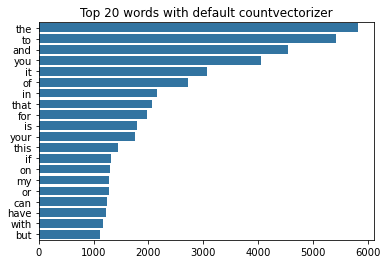

In [93]:
sns.barplot(y=list(cvec_top_20.index), x=cvec_top_20.values, orient='h', color='tab:blue')
plt.title("Top 20 words with default countvectorizer");

There are a vast amount of stop words (nouns and pronouns) in our submission data. Let's try and cut that down using the default stopwords list in the count vectorizer class.

In [94]:
cvec2 = CountVectorizer(stop_words='english')

In [95]:
X_train_cvec2 = pd.DataFrame(cvec2.fit_transform(X_train).A, columns=cvec2.get_feature_names_out())
X_test_cvec2 = pd.DataFrame(cvec2.transform(X_test).A, columns=cvec2.get_feature_names_out())
X_train_cvec2.head(5)

,00,000,00001,026_007_plumb_repair,03,03am,04,054fd209,08,087,...,還是因為距離,還會陷入愛情嗎,那些懵懂而青澀的過往,那些沒有結果的感情,那個你本以為忘記的人,都成眷屬,都會實現,都會結果,都有可能改變你的生活,餘生
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [96]:
print(X_train_cvec2.shape, X_test_cvec2.shape)

(1857, 12084) (619, 12084)


In [97]:
X_train_cvec2.shape[1] - X_train_cvec.shape[1]

-289

We have 289 less columns in our vectorization without stop words.

In [98]:
cvec2_top_20 = X_train_cvec2.sum().sort_values(ascending=False)[:20]
cvec2_top_20

just      747
don       660
like      631
time      579
people    487
know      412
make      399
ve        360
work      343
want      341
way       321
use       315
need      296
life      268
really    257
help      246
things    246
day       233
feel      227
good      219
dtype: int64

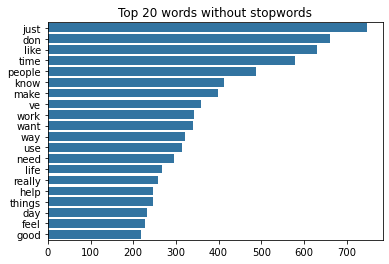

In [99]:
sns.barplot(y=list(cvec2_top_20.index), x=cvec2_top_20.values, orient='h', color='tab:blue')
plt.title("Top 20 words without stopwords");

Stop words have been cut down; however, the frequency of the new words are a lot less than the frequency of stop words.
We also have a lot more adverbs in hour list.

Let's now tokenize our words using uni- and bigrams, and see what patterns emerge.

In [126]:
cvec3 = CountVectorizer(stop_words='english', ngram_range=(2, 2))

In [127]:
X_train_cvec3 = pd.DataFrame(cvec3.fit_transform(X_train).A, columns=cvec3.get_feature_names_out())
X_test_cvec3 = pd.DataFrame(cvec3.transform(X_test).A, columns=cvec3.get_feature_names_out())
X_train_cvec3.head(5)

,00 apy,00 didn,00 lowest,00 mashing,00 pair,000 100,000 11,000 calories,000 doubled,000 dual,...,還是因為距離 還是因為每個人各自的苦衷,還會陷入愛情嗎 即便再來一次,那些懵懂而青澀的過往 卻會是我們一生的珍藏,那些沒有結果的感情 結局不完美,那個你本以為忘記的人 就會像蜜蜂蟄了心,都成眷屬 人生有得失,都會實現 不是每一對戀人,都會結果 不是每一次心願,都有可能改變你的生活 主播,餘生 希望彼此都能把對方放下
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [128]:
print(X_train_cvec3.shape, X_test_cvec3.shape)

(1857, 65514) (619, 65514)


In [129]:
X_train_cvec3.shape[1] - X_train_cvec.shape[1]

53141

We have 65,225 more columns by tokenizing our words into uni- and bigrams.

In [130]:
cvec3_top_20 = X_train_cvec3.sum().sort_values(ascending=False)[:20]
cvec3_top_20

https www        79
make sure        75
don know         69
don want         65
feel like        56
amp x200b        52
don need         26
long time        26
ice cream        25
things like      25
credit card      24
just like        22
tiger19 tw       21
https tiger19    21
best way         21
years ago        20
lot people       20
let know         19
just need        19
don let          18
dtype: int64

A fair amount of bigrams appear to include the word "don" which seems to be a typo of the word "don't".

---

Let's try to capture words that fall more inbetween, and drop the stop words. Ideally, we will get more substance in our tokens.

In [222]:
cvec4 = CountVectorizer(stop_words='english', min_df=2, max_df=.05)

In [223]:
X_train_cvec4 = pd.DataFrame(cvec4.fit_transform(X_train).A, columns=cvec4.get_feature_names_out())
X_test_cvec4 = pd.DataFrame(cvec4.transform(X_test).A, columns=cvec4.get_feature_names_out())
X_train_cvec4.head(5)

,00,000,03,04,09,10,100,1000,10mm,10pm,...,youtube,youtubers,yr,ysk,yt,zero,zip,zipper,zone,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [224]:
print(X_train_cvec3.shape, X_test_cvec3.shape)

(1857, 65514) (619, 65514)


In [225]:
X_train_cvec4.shape[1] - X_train_cvec.shape[1]

-6678

We have 6341 less columns in our vectorization that removes all tokens that appear only once.

In [226]:
cvec4_top_20 = X_train_cvec4.sum().sort_values(ascending=False)[:20]
cvec4_top_20

amp         210
com         160
job         152
car         139
phone       138
food        131
didn        117
tell        115
friends     114
buy         112
year        109
home        109
place       108
days        108
away        108
hard        107
thought     106
actually    103
makes       102
family      102
dtype: int64

Both train and test splits have been successfully vectorized. We have generated 12,373 unique strings of characters to use as features.

### Baseline Model

Let's create a baseline model to compare our results.

In [8]:
dc = DummyClassifier()

In [9]:
make_model(dc, X_train_cvec, X_test_cvec, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.7587506731287023
        Test Accuracy Score: 0.7592891760904685
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.0
        Specificity: 1.0
        Precision: 0.0
        
        Balance Accuracy: 0.5
        F1 Score: 0.0
        


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- Regarding accuracy, 75.9% of our predictions correctly predicted if a posts belongs to `r/LifeProTips` or `r/lifehacks`.

- Regarding recall, the proportion of correctly predicted `r/lifehacks` posts over actual `r/lifehacks` posts. <br />
In this case we did not correctly predict any posts belong to `r/lifehacks`.

- Regarding specificity, the proportion of correctly predicted `r/LifeProTips` posts over actual `r/LifeProTips` posts. <br />
In this case we correctly predicted all `r/LifeProTips` posts that belong to `r/LifeProTips`.

- Regarding precision, the proportion of correct `r/lifehacks` predictions over all `r/lifehacks` predictions. <br />
Since we did not predict any post to belong to `r/lifehacks`, our precision score cannot be calculated (can't divide by zero). Defaults to zero instead.

- Our balanced accuracy score is the average of our recall and specificty score. It's important for us here because our data is imbalanced (far more cases of `r/LifeProTips` than `r/lifehacks`). <br />
Here we can see that our model is not doing a good job of predicting both classes correctly.

Given that our recall score is `0`, and our specifity score is `1`, our baseline model simply predicted all posts in the dataset to belong to `r/LifeProTips`! <br />
That means we incorrectly predicted about `30%` of our data, hence our accuracy score of 0.759.

F1 score....

### Logistic Regression

Alias: Kronk

In [10]:
lr = LogisticRegression(max_iter=1_000, random_state=14)

In [11]:
make_model(lr, X_train_cvec, X_test_cvec, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.9983844911147012
        Test Accuracy Score: 0.7366720516962844
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.35570469798657717
        Specificity: 0.8574468085106383
        Precision: 0.44166666666666665
        
        Balance Accuracy: 0.6065757532486077
        F1 Score: 0.3940520446096654
        


Verdict: Worse than our baseline in terms of accuracy.

In [12]:
kronk_coefs = pd.DataFrame(lr.coef_[0], index=X_train_cvec.columns)
kronk_coefs.sort_values(by=0, ascending=False)

,0
hack,1.316535
tried,1.203418
tips,1.167859
oil,0.963483
any,0.821774
...,...
people,-0.749673
money,-0.827517
often,-0.844439
many,-0.859666


Higher scores correlate with `r/lifehack` and lower scores correlate with `r/LifeProTips`.

#### Kronk v2.0

In [13]:
lr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 14,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [14]:
lr_gs = GridSearchCV(
    LogisticRegression(max_iter=1_000, random_state=14),
    param_grid={
        'C': [1, 5, 10]
    },
    n_jobs=-1
)
lr_gs

GridSearchCV(estimator=LogisticRegression(max_iter=1000, random_state=14),
             n_jobs=-1, param_grid={'C': [1, 5, 10]})

In [15]:
make_model(lr_gs, X_train_cvec, X_test_cvec, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.9983844911147012
        Test Accuracy Score: 0.7366720516962844
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.35570469798657717
        Specificity: 0.8574468085106383
        Precision: 0.44166666666666665
        
        Balance Accuracy: 0.6065757532486077
        F1 Score: 0.3940520446096654
        


In [17]:
lr_gs.best_params_

{'C': 1}

For some reason this is not working on 'saga' solver!!

In [ ]:
lr_gs2 = GridSearchCV(
    LogisticRegression(penalty='l1', max_iter=1_000, random_state=14, solver='saga'),
    param_grid={
        'C': [0.1, 0.5, 1]
    },
    n_jobs=-1
)
lr_gs2

In [ ]:
#make_model(lr_gs2, X_train_cvec, X_test_cvec, y_train_encoded, y_test_encoded)

### K-Nearest-Neighbors

Alisas: Kuzko

In [44]:
knn = KNeighborsClassifier(n_jobs=-1)

In [73]:
make_model(knn, X_train_cvec, X_test_cvec, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.8056004308023694
        Test Accuracy Score: 0.7221324717285945
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.24161073825503357
        Specificity: 0.874468085106383
        Precision: 0.37894736842105264
        
        Balance Accuracy: 0.5580394116807083
        F1 Score: 0.29508196721311475
        


While the accuracy is better, the recall and precision score went down. This tells us that the model made more correct `r/LifeProTips` predictions, and more incorrect `r/lifehacks`. <br />
Verdict: Worse than Kronk model.

In [30]:
knn_gs = GridSearchCV(
    KNeighborsClassifier(n_jobs=-1),
    param_grid={
        'n_neighbors': [20, 25, 30, 35]
    },
    n_jobs=-1
)
knn_gs

GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'n_neighbors': [20, 25, 30, 35]})

In [31]:
make_model(knn_gs, X_train_cvec, X_test_cvec, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.7587506731287023
        Test Accuracy Score: 0.7576736672051696
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.006711409395973154
        Specificity: 0.9957446808510638
        Precision: 0.3333333333333333
        
        Balance Accuracy: 0.5012280451235185
        F1 Score: 0.013157894736842106
        


In [32]:
knn_gs.best_params_

{'n_neighbors': 30}

### Bagging Classifier

Alias: Yzma

In [59]:
bc = BaggingClassifier(random_state=14, n_jobs=-1)

In [74]:
make_model(bc, X_train_cvec, X_test_cvec, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.975767366720517
        Test Accuracy Score: 0.7625201938610663
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.1476510067114094
        Specificity: 0.9574468085106383
        Precision: 0.5238095238095238
        
        Balance Accuracy: 0.5525489076110239
        F1 Score: 0.23036649214659685
        


Looks like Yzma model is making less predictions of `r/lifehacks`; however, the few that it does predict, it's getting more of those correct, hence why our precision score has increased.
Slight improvement over the Kuzko model.

In [34]:
bc_gs = GridSearchCV(
    BaggingClassifier(random_state=14, n_jobs=-1),
    param_grid={
        'n_estimators' : [5, 10, 25, 50, 100],
        'bootstrap_features': [False, True]
    },
    n_jobs=-1
)
bc_gs

GridSearchCV(estimator=BaggingClassifier(n_jobs=-1, random_state=14), n_jobs=-1,
             param_grid={'bootstrap_features': [False, True],
                         'n_estimators': [5, 10, 25, 50, 100]})

In [35]:
make_model(bc_gs, X_train_cvec, X_test_cvec, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.9983844911147012
        Test Accuracy Score: 0.7625201938610663
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.1610738255033557
        Specificity: 0.9531914893617022
        Precision: 0.5217391304347826
        
        Balance Accuracy: 0.5571326574325289
        F1 Score: 0.24615384615384617
        


In [36]:
bc_gs.best_params_

{'bootstrap_features': False, 'n_estimators': 50}

### Random Forests

Alias: Pacha

In [77]:
rf = RandomForestClassifier(random_state=14, n_jobs=-1)

In [78]:
make_model(rf, X_train_cvec, X_test_cvec, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 1.0
        Test Accuracy Score: 0.7705977382875606
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.06711409395973154
        Specificity: 0.9936170212765958
        Precision: 0.7692307692307693
        
        Balance Accuracy: 0.5303655576181636
        F1 Score: 0.12345679012345678
        


Our recall has gone down significantly, which indicates very few predictions for `r/lifehacks` were made. The few predictions that were made about `r/lifehacks` were mostly correct, which is why we have a relatively high precision score.

Making few predictoins for `r/lifehacks` is not ideal for us. Does not outperform Yzma model.

In [38]:
rf_gs = GridSearchCV(
    RandomForestClassifier(random_state=14, n_jobs=-1),
    param_grid={
        'n_estimators': [100, 150, 200],
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 3, 5]
    },
    n_jobs=-1
)
rf_gs

GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=14),
             n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 15],
                         'min_samples_split': [2, 3, 5],
                         'n_estimators': [100, 150, 200]})

In [39]:
make_model(rf_gs, X_train_cvec, X_test_cvec, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 1.0
        Test Accuracy Score: 0.7705977382875606
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.06711409395973154
        Specificity: 0.9936170212765958
        Precision: 0.7692307692307693
        
        Balance Accuracy: 0.5303655576181636
        F1 Score: 0.12345679012345678
        


In [40]:
rf_gs.best_params_

{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}

In [60]:
pd.DataFrame(rf_gs.best_estimator_.feature_importances_, index=X_train_cvec.columns).sort_values(by=0, ascending=False)

,0
hack,0.007384
you,0.006622
tried,0.004729
to,0.004566
https,0.004552
...,...
couldnt,0.000000
offhand,0.000000
counselors,0.000000
offensive,0.000000


### Extra Trees

Alias: Chaca

In [81]:
et = ExtraTreesClassifier(random_state=14, n_jobs=-1)

In [82]:
make_model(et, X_train_cvec, X_test_cvec, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 1.0
        Test Accuracy Score: 0.778675282714055
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.12080536912751678
        Specificity: 0.9872340425531915
        Precision: 0.75
        
        Balance Accuracy: 0.5540197058403541
        F1 Score: 0.20809248554913296
        


Higher recall score than Pacha model (makes more `r/lifehacks` predictions) while maintaining essentially the same precision score (same correct/incorrect ratio predictions of `r/lifehacks`). This is a slight imporovement of the Pacha and Yzma model. 

In [41]:
et_gs = GridSearchCV(
    ExtraTreesClassifier(random_state=14, n_jobs=-1),
    param_grid={
        'n_estimators': [100, 150, 200],
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 3, 5]
    },
    n_jobs=-1
)
et_gs

GridSearchCV(estimator=ExtraTreesClassifier(n_jobs=-1, random_state=14),
             param_grid={'max_depth': [None, 5, 10, 15],
                         'min_samples_split': [2, 3, 5],
                         'n_estimators': [100, 150, 200]})

In [42]:
make_model(et_gs, X_train_cvec, X_test_cvec, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 1.0
        Test Accuracy Score: 0.778675282714055
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.12080536912751678
        Specificity: 0.9872340425531915
        Precision: 0.75
        
        Balance Accuracy: 0.5540197058403541
        F1 Score: 0.20809248554913296
        


In [61]:
pd.DataFrame(et_gs.best_estimator_.feature_importances_, index=X_train_cvec.columns).sort_values(by=0, ascending=False)

,0
hack,0.008882
hacks,0.005128
tried,0.004048
tips,0.003809
you,0.003743
...,...
cosmic,0.000000
costco,0.000000
costing,0.000000
proxy,0.000000


### Ada Boost Classifier

Alias: Tipo

In [85]:
abc = AdaBoostClassifier(random_state=14)

In [86]:
make_model(abc, X_train_cvec, X_test_cvec, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.8136779752288638
        Test Accuracy Score: 0.7576736672051696
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.28859060402684567
        Specificity: 0.9063829787234042
        Precision: 0.4942528735632184
        
        Balance Accuracy: 0.597486791375125
        F1 Score: 0.3644067796610169
        


It appears more predictions were made for `r/lifehacks` (higher recall score) but the amount of correct predictions went down (lower precision score). Our F1 score is only second to the Kronk model.

In [44]:
abc_gs = GridSearchCV(
    AdaBoostClassifier(random_state=14),
    param_grid={
        'n_estimators': [100, 150, 200, 250]
    },
    n_jobs=-1
)
abc_gs

GridSearchCV(estimator=AdaBoostClassifier(random_state=14), n_jobs=-1,
             param_grid={'n_estimators': [100, 150, 200, 250]})

In [45]:
make_model(abc_gs, X_train_cvec, X_test_cvec, y_train_encoded, y_test_encoded)


        Training Accuracy Score: 0.8933764135702746
        Test Accuracy Score: 0.7447495961227787
        
        --- Performance on unseen data ----
        Recall (Sensitivity): 0.30201342281879195
        Specificity: 0.8851063829787233
        Precision: 0.45454545454545453
        
        Balance Accuracy: 0.5935599028987577
        F1 Score: 0.3629032258064516
        


In [46]:
abc_gs.best_params_

{'n_estimators': 150}

In [62]:
pd.DataFrame(abc_gs.best_estimator_.feature_importances_, index=X_train_cvec.columns).sort_values(by=0, ascending=False)

,0
at,0.020000
often,0.013333
tips,0.013333
time,0.013333
be,0.013333
...,...
eyeball,0.000000
eyebrow,0.000000
eyeglasses,0.000000
eyeing,0.000000


-----

Now that we have found the best estimators in our gridsearches, let's ensemble all our models for the best possible classifications.

In [236]:
vr = VotingClassifier(
    [
        (lr_gs.best_estimator_),
        (knn_gs.best_estimator_),
        (bc_gs.best_estimator_),
        (rf_gs.best_estimator_),
        (et_gs.best_estimator_),
        (abc_gs.best_estimator_)
    ],
    n_jobs=-1
)
vr

VotingClassifier(estimators=[LogisticRegression(C=1, max_iter=1000,
                                                random_state=14),
                             KNeighborsClassifier(n_jobs=-1, n_neighbors=30),
                             BaggingClassifier(n_estimators=50, n_jobs=-1,
                                               random_state=14),
                             RandomForestClassifier(n_jobs=-1, random_state=14),
                             ExtraTreesClassifier(n_jobs=-1, random_state=14),
                             AdaBoostClassifier(n_estimators=150,
                                                random_state=14)],
                 n_jobs=-1)

In [ ]:
make_model(vr, X_train_cvec, X_test_cvec, y_train_encoded, y_test_encoded)